In [1]:
%config Completer.use_jedi = False

In [2]:
import os
from collections import defaultdict
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import scipy
from scipy.stats import multivariate_normal

In [3]:
from vae_model import VAE

In [4]:
def load_pickle(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    train_data, test_data = data['train'] > 255/2, data['test'] > 255/2
    train_labels, test_labels = data['train_labels'], data['test_labels']
    return train_data, test_data, train_labels, test_labels


def show_samples(samples, title=None, nrow=10):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure(figsize=(10,10))
    if title is not None:
        plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


def visualize_data(data, title):
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)
    

def visualize_batch(batch, nrow=10):
    show_samples(batch[...,None], nrow=nrow)


def plot_training_curves(train_losses, test_losses):
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + '_train')

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + '_test')

    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [6]:
train_data, test_data, train_labels, test_labels = load_pickle('mnist.pkl')

In [ ]:
visualize_data(train_data, 'MNIST samples')

In [7]:
# TODO: plot one sample

In [8]:
def train_epoch(model, train_loader, optimizer, epoch, loss_key='total'):
    model.train()
    stats = defaultdict(list)
    for x in train_loader:
        #x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())
    return stats


def eval_model(model, data_loader):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            #x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(model, train_loader, test_loader, epochs, lr, loss_key='total'):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, epoch, loss_key)
        test_loss = eval_model(model, test_loader)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)


def solve_task(train_data, test_data, model, batch_size, epochs, lr):
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

    train_losses, test_losses = train_model(
        model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
    )
    
    for key, value in test_losses.items():
        print('{}: {:.4f}'.format(key, value[-1]))

    plot_training_curves(train_losses, test_losses)

In [9]:
ENC_HIDDEN_SIZES = [128, 64, 32]
DEC_HIDDEN_SIZES = [32, 64, 128]
BATCH_SIZE = 128
EPOCHS = 20
LR = 0.003

In [10]:
model = VAE(28*28, 2, ENC_HIDDEN_SIZES, DEC_HIDDEN_SIZES).float()

elbo_loss: 137.5834
recon_loss: 130.7709
kl_loss: 6.8126


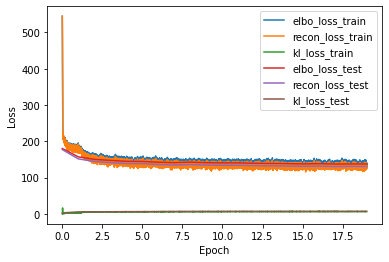

In [11]:
train_loader = DataLoader(train_data[...,0].astype(np.float32), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data[...,0].astype(np.float32), batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model, train_loader, test_loader, epochs=EPOCHS, lr=LR, loss_key='elbo_loss'
)

for key, value in test_losses.items():
    print('{}: {:.4f}'.format(key, value[-1]))

plot_training_curves(train_losses, test_losses)

In [12]:
# look at the batch, and samples

In [ ]:
############

In [18]:
def get_batch_of_labels(label, batch_size, data_with_labels=(test_data, test_labels)):
    data, labels = data_with_labels
    idx = np.random.choice(np.argwhere(labels == label).flatten(), batch_size, replace=False)
    
    return data[idx][...,0]

In [19]:
# TODO: look at z for bathces of the same elements
# plot N(0,1)

In [20]:
def get_pdf(mu, sigma):
    x, y = np.mgrid[-5:5:0.05, -5:5:0.05]
    pos = np.dstack((x, y))
    rv = multivariate_normal(mu, [[sigma[0], 0],[0, sigma[0]]])
    return rv.pdf(pos)

def get_pic(mu, sigma):
    res = get_pdf(mu, sigma)
    pic = res.T[::-1,:]
    
    return pic

def get_pics(mu_s, sigma_s):
    return np.array([get_pic(m, s) for m,s in zip(mu_s, sigma_s)])

In [22]:
# TODO: look at samples from laten's grid